## Convolutional Layaer

Convolutional layer scratch development

In [133]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

%load_ext autoreload 
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = torchvision.datasets.MNIST(root='./data/mnist_data', train=True, download=True)
im, label =dataset[0]
im = transforms.ToTensor()(im)[0,:,:]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4643004.18it/s]


Extracting ./data/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 141667.24it/s]


Extracting ./data/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1327693.95it/s]


Extracting ./data/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2989256.04it/s]

Extracting ./data/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist_data/MNIST/raw



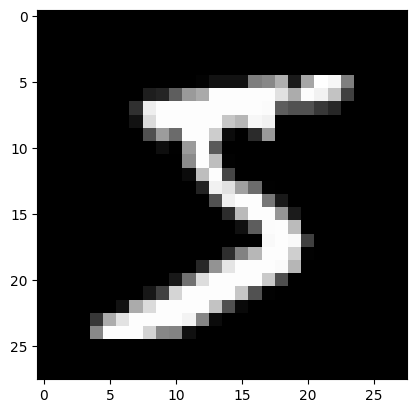

In [4]:
plt.imshow(im, cmap='gray')

In [45]:
import pandas as pd
df = pd.DataFrame(im)
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Top edge filter

$\begin{bmatrix}
-1 & -1 & -1\\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}$

In [26]:
top_edge_filter = torch.tensor([[-1.,-1.,-1.],
                                 [0.,0.,0.],
                                 [1.,1.,1.]])
top_edge_filter

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [64]:
def apply_filter(im, filter):
    im_h,im_w = im.shape
    f_h,f_w = filter.shape
    
    height = im_h - f_h + 1
    width = im_w - f_w + 1
    
    output_data= []
    
    for h in range(height):
        row = []
        for w in range(width):
            row.append((im[h:h+f_h,w:w+f_w] * filter).sum().item())
        output_data.append(row)
    
    return output_data

In [79]:
top_filtered_im = apply_filter(im, top_edge_filter)

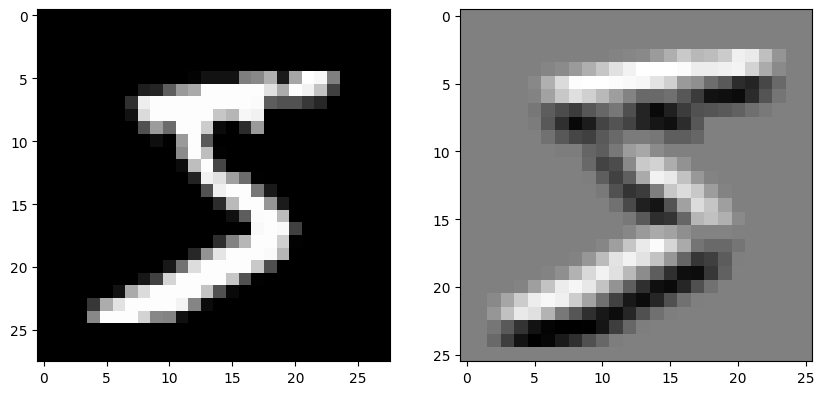

In [80]:
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1) 
plt.imshow(im, cmap='gray')
fig.add_subplot(1, 2, 2) 
plt.imshow(top_filtered_im, cmap='gray')


### Left edge filter

$\begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}$

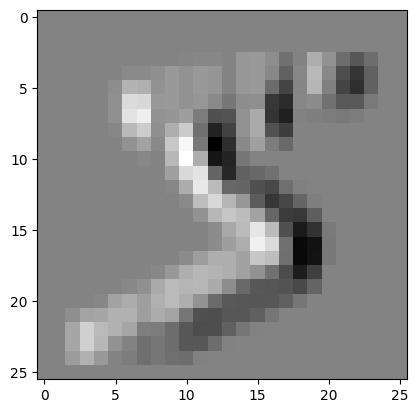

In [81]:
left_edge_filter = torch.tensor([[-1.,0.,1.],
                                 [-1.,0.,1.],
                                 [-1.,0.,1.]])
left_filtered_im = apply_filter(im, left_edge_filter)
plt.imshow(left_filtered_im, cmap='gray')

Text(0.5, 1.0, 'Left edge filter')

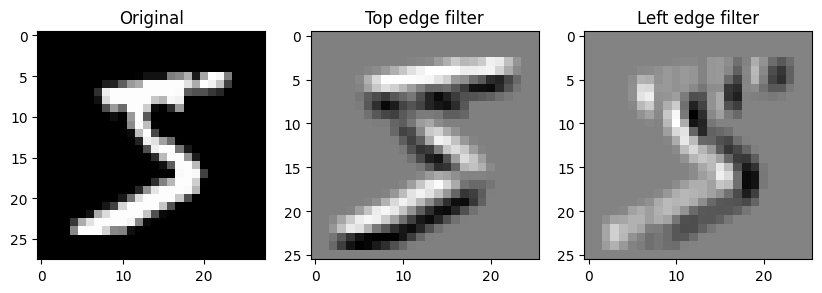

In [82]:
fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(im, cmap='gray')
plt.title('Original')
fig.add_subplot(1, 3, 2) 
plt.imshow(top_filtered_im, cmap='gray')
plt.title('Top edge filter')
fig.add_subplot(1, 3, 3) 
plt.imshow(left_filtered_im, cmap='gray')
plt.title('Left edge filter')

### Stride and Padding

**Stride**
Stdie denotes how many steps a filter is moving in each steps in convolution.

<img src="./rsc/stride.gif" width="600" height="800">

**Padding**
The size of output is smaller that input. To maintain the dimension of output as in input , padding is used. Padding is a process of adding zeros to the input matrix symmetrically. <br>

Example: <br>
Input = 5x5, stride = 1, padding=1, Output = 5x5 <br>

<img src="./rsc/stride_with_padding.gif" width="600" height="800">


#### Calculate output size
$W_{out} = [\frac{W_{in}-F+2P}{S}] + 1$ <br>

$H_{out} = [\frac{H_{in}-F+2P}{S}] + 1$ <br>

$W_{in}$, $H_{in}$: Width, height of input  <br>
$F$: filter size <br>
$S$: stride size <br>

When F=3, P=1, S=1, size of output is the same with that of input  <br>
When F=3, P=1, S=2, size of output is a half of input (each axis) <br>

By changing the stride and padding, you could adjust output size. <br>

**Convolutional Layer in CNN** <br>

Commonly using F=3, P=1, S=2 reduces the size while the number of channel increases
<img src="./rsc/sample_NN-SVG.png" width="600" height="800">

[NN-SVG](https://alexlenail.me/NN-SVG/AlexNet.html)

In [84]:
from torch import nn

### Building CNN

<img src="./rsc/sample_CNN.png" width="600" height="800">

#### CNN model

In [125]:
conv_model=nn.Sequential(
        # 1x28x28
        nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 32x2x2
    
        # one way
        # nn.flatten()
        # # 128
        # nn.Linear(128,10)
    
        # if only use Conv2d
        nn.Conv2d(in_channels=32,out_channels=10 , kernel_size=3, stride=2,padding=1),
        nn.Flatten()
        # 10
)

In [89]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [90]:
X = torch.randn(8,1,28,28)
output = conv_model(X)

In [91]:
output.shape

torch.Size([8, 10])

`torch.numel`(input) → int<br>
Returns the total number of elements in the input tensor.

In [99]:
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(9034)

#### Learning with MNIST data

In [127]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data/mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data/mnist_data', download=True, transform=transform)

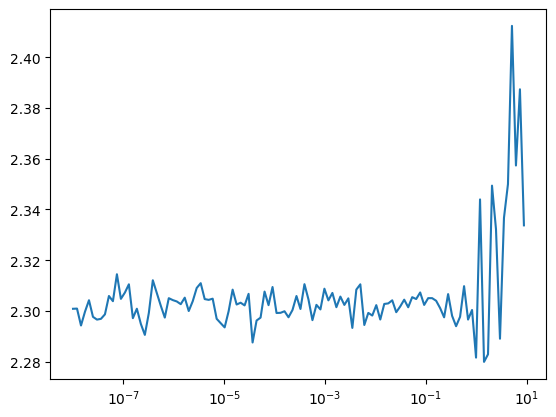

In [131]:
conv_model=nn.Sequential(
        # 1x28x28
        nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 32x2x2
    
        # one way
        # nn.flatten()
        # # 128
        # nn.Linear(128,10)
    
        # if only use Conv2d
        nn.Conv2d(in_channels=32,out_channels=10 , kernel_size=3, stride=2,padding=1),
        nn.Flatten()
        # 10
)

batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

lrs, losses = utils.lr_finder(conv_model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')
# train_losses, val_losses, val_accuracies, best_val_loss = learning(model, train_loader, val_loader, opt, F.cross_entropy, num_epochs=100, early_stopping=5)

In [157]:
from datetime import datetime 
import time
import os

In [149]:
date_str = datetime.today().strftime('%Y_%m_%d')
if not os.path.exists(f'./model/{date_str}'):
    os.mkdir(f'./model/{date_str}')

epoch: 0: train error: 0.7085770283108835, validation error: 0.16147323577269626, validation accuracy: 0.9501876776406506


epoch: 1: train error: 0.147072311308084, validation error: 0.10933887801055651, validation accuracy: 0.9655961264679427


epoch: 2: train error: 0.1043023279210779, validation error: 0.1024180280703948, validation accuracy: 0.9691775497088808


epoch: 3: train error: 0.08284630492599661, validation error: 0.08267354799001646, validation accuracy: 0.9739972014925373


epoch: 4: train error: 0.07089556336873519, validation error: 0.06477287626598896, validation accuracy: 0.9797385838240195


epoch: 5: train error: 0.0637332773807127, validation error: 0.06436042851313695, validation accuracy: 0.9786225123954481


epoch: 6: train error: 0.05810773652096563, validation error: 0.044715970040990045, validation accuracy: 0.9856965174552983


epoch: 7: train error: 0.0556414517994001, validation error: 0.051538939290900414, validation accuracy: 0.9834255063965884


epoch: 8: train error: 0.05121555683592251, validation error: 0.041652494780237734, validation accuracy: 0.9866571162046909


epoch: 9: train error: 0.04789189390315891, validation error: 0.044914692657928204, validation accuracy: 0.9861740405117271


epoch: 10: train error: 0.04572773096002718, validation error: 0.04528489042764037, validation accuracy: 0.9854577558635395


epoch: 11: train error: 0.045553598380677386, validation error: 0.03416131854182415, validation accuracy: 0.9891113628710765


epoch: 12: train error: 0.04191869652188663, validation error: 0.03428505704778411, validation accuracy: 0.9890114161759805


epoch: 13: train error: 0.040780011259430426, validation error: 0.04097880557604404, validation accuracy: 0.9868014836107998


epoch: 14: train error: 0.03929412576344126, validation error: 0.03258124939202001, validation accuracy: 0.9895999910734864
Time to complete: 177.48 seconds


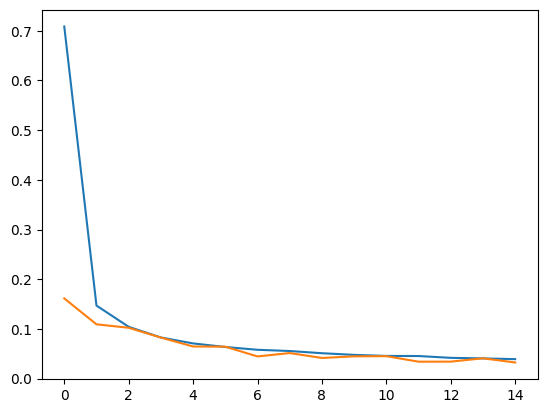

In [162]:
conv_model=nn.Sequential(
        # 1x28x28
        nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 4x14x14
        nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 8x7x7
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 16x4x4
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, stride=2,padding=1), 
        nn.ReLU(),
        # 32x2x2
    
        # one way
        # nn.flatten()
        # # 128
        # nn.Linear(128,10)
    
        # if only use Conv2d
        nn.Conv2d(in_channels=32,out_channels=10 , kernel_size=3, stride=2,padding=1),
        nn.Flatten()
        # 10
)

learning_rate = 0.3
opt = optim.SGD(params=conv_model.parameters(), lr=learning_rate)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

num_epoch = 15
early_stopping = 5
save_path = f'./model/{date_str}/checkpoint'
start = time.time()
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path)
end = time.time()
print(f'Time to complete: {(end-start):.2f} seconds')

plt.plot(train_losses)
plt.plot(val_losses)